## Import Libraries
### Import necessary libraries for data processing, visualization, model building, and evaluation.

In [1]:
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import librosa
import librosa.display

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from keras._tf_keras.keras.models import Sequential, load_model
from keras._tf_keras.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras._tf_keras.keras.utils import to_categorical

# Set the dataset path
location = Path("Datasets/TESS/")

## Utility Functions for Feature Extraction and Data Augmentation
### Functions for extracting MFCC features, adding noise, time-shifting, and time-stretching.

In [2]:
def extract_mfcc_features(audio_path_or_waveform, sr=None, max_pad_len=500):
    # Extract MFCC features and pad them to ensure consistent length.
    if isinstance(audio_path_or_waveform, str):
        y, sr = librosa.load(audio_path_or_waveform, sr=sr)
    else:
        y = audio_path_or_waveform

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs.T

def add_noise(y, noise_factor=0.005):
    # Add Gaussian noise to audio.
    noise = np.random.randn(len(y))
    y_noise = y + noise_factor * noise
    return np.clip(y_noise, -1.0, 1.0)

def time_shift(y, shift_max=2):
    # Perform time-shifting on audio.
    shift = random.randint(-shift_max, shift_max)
    return np.roll(y, shift)

def time_stretch(y, rate=1.1):
    # Perform time-stretching on audio.
    return librosa.effects.time_stretch(y, rate=rate)

## Load Data Function
### This function loads the dataset, extracts features, and applies data augmentation if enabled.

In [3]:
def load_data(dataset_path, augment=False):
    # Load audio data, extract features, and apply data augmentation.
    features = []
    labels = []
    
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for file in os.listdir(label_path):
            if file.endswith(".wav"):  # Assuming audio files are in WAV format
                file_path = os.path.join(label_path, file)
                
                # Extract MFCC features from the original audio
                y, sr = librosa.load(file_path, sr=None)
                mfcc_features = extract_mfcc_features(y, sr=sr)
                features.append(mfcc_features)  # Add original features
                labels.append(label)
                
                if augment:
                    # Data Augmentation
                    features.append(extract_mfcc_features(add_noise(y), sr=sr))  # Noise-added
                    features.append(extract_mfcc_features(time_shift(y), sr=sr))  # Time-shifted
                    features.append(extract_mfcc_features(time_stretch(y, rate=1.1), sr=sr))  # Time-stretched
                    labels.extend([label] * 3)  # Same label for augmented samples
    
    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    # Pad or truncate features to have consistent shape
    max_length = max([x.shape[0] for x in features])
    features = [np.pad(x, ((0, max_length - x.shape[0]), (0, 0)), mode='constant') for x in features]
    
    return np.array(features), to_categorical(np.array(labels)), label_encoder

## Prepare Data
### Load and preprocess the dataset, including feature extraction and data splitting.

In [4]:
X, y, label_encoder = load_data(location, augment=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [5]:
X_train.shape

(8960, 500, 40)

In [6]:
X_test.shape

(2240, 500, 40)

#### Data Exploration

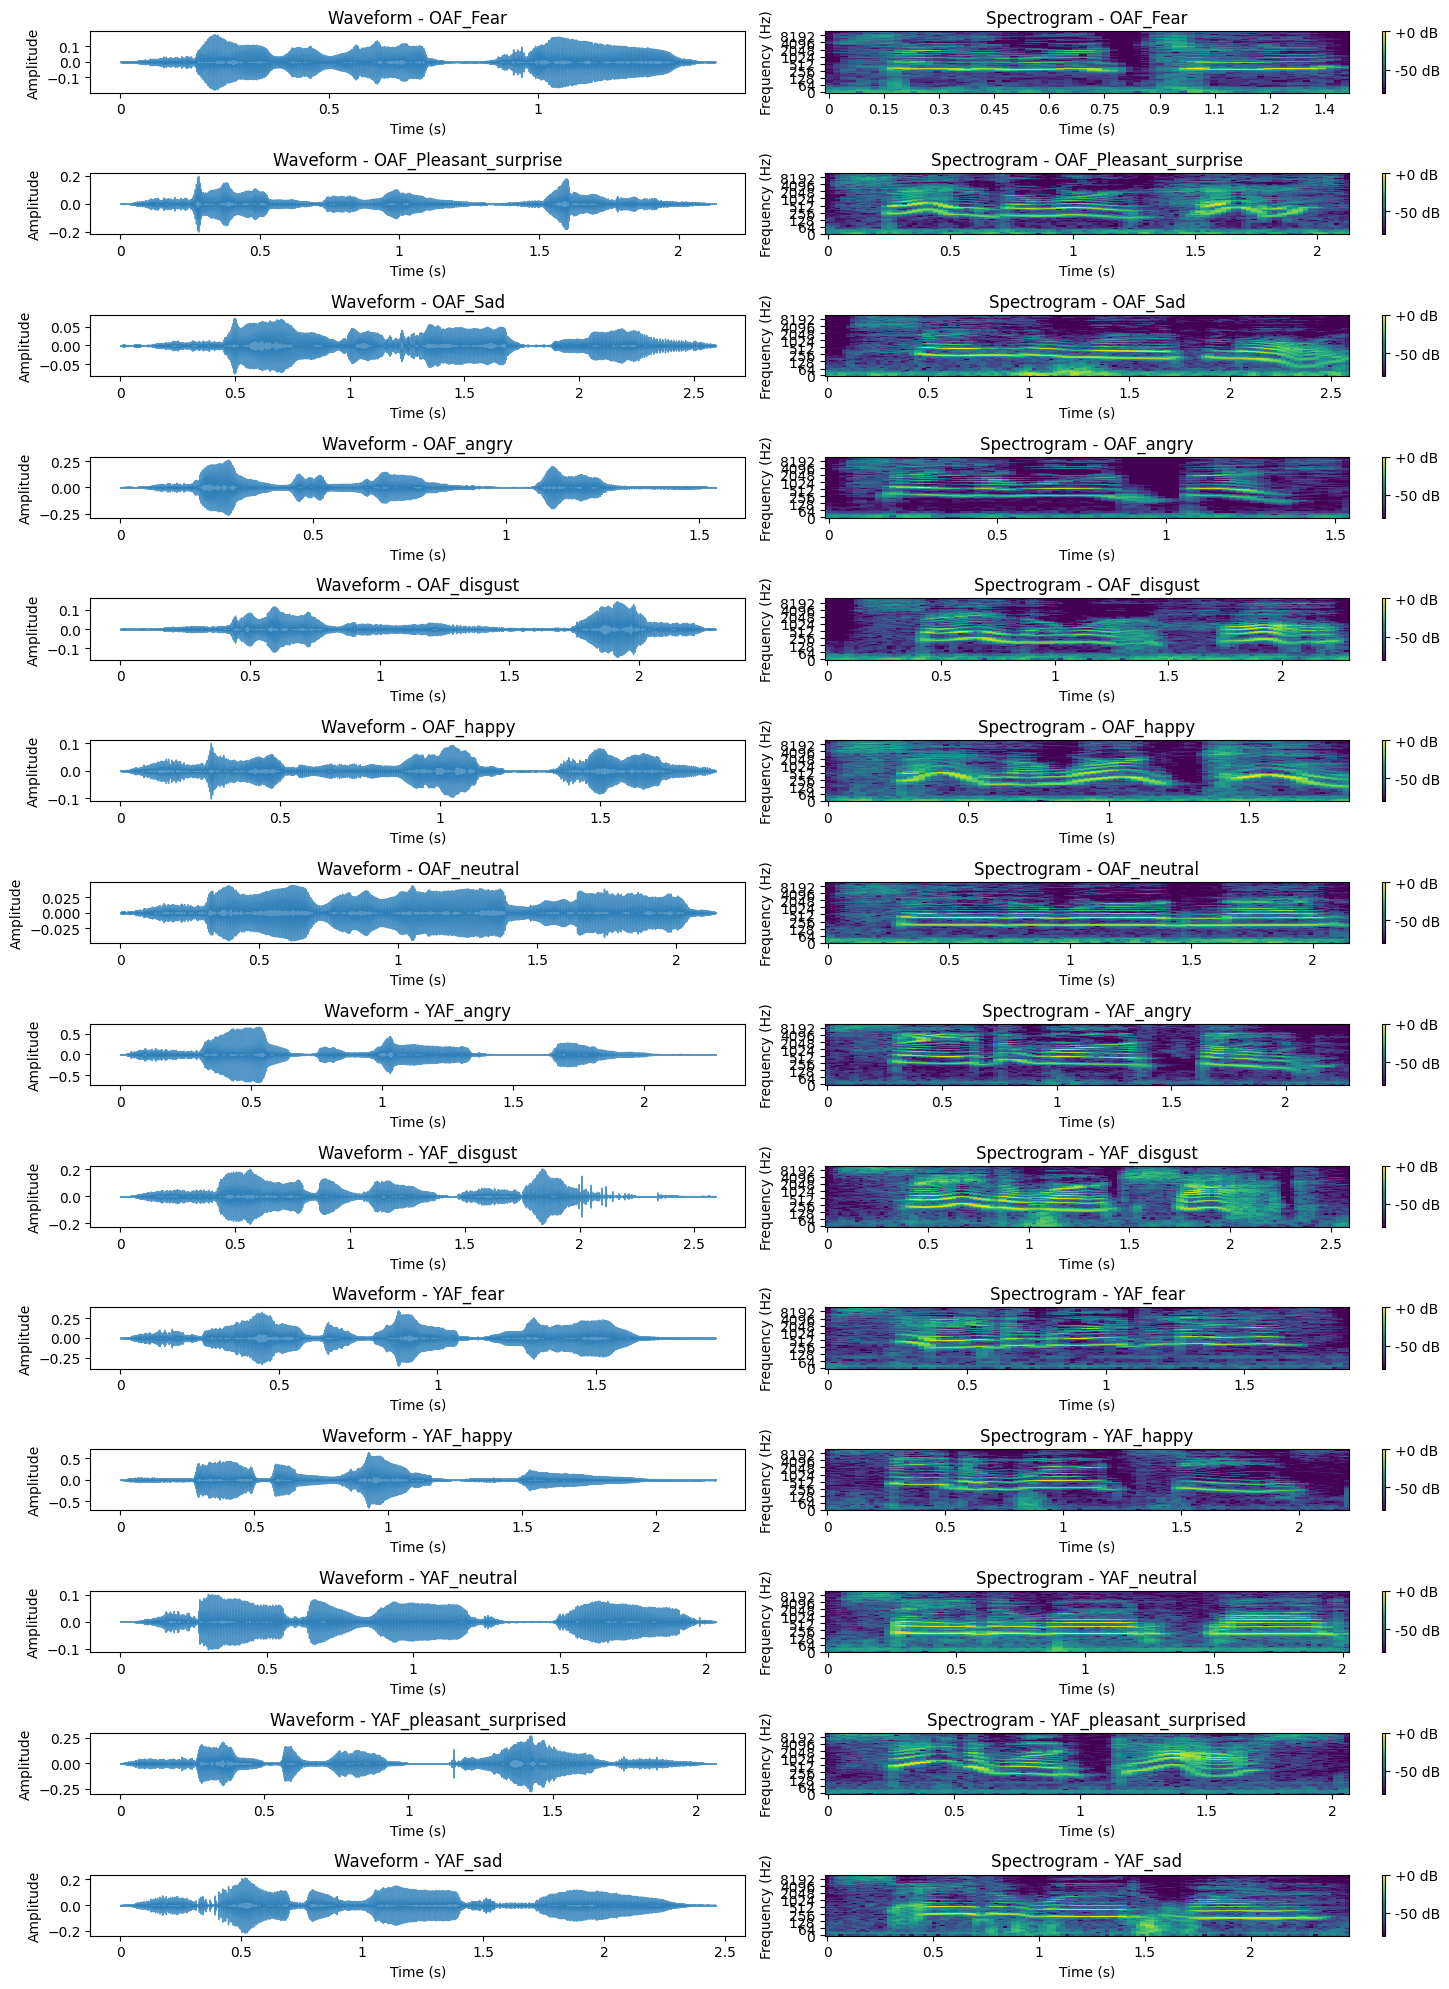

In [7]:
def plot_waveform_and_spectrogram(dataset_path, label_encoder, sample_rate=None):
    plt.figure(figsize=(15, 20))
    emotions = label_encoder.classes_

    for i, emotion in enumerate(emotions):
        emotion_path = os.path.join(dataset_path, emotion)
        if not os.path.exists(emotion_path):
            continue
        
        # Select a random audio file from the emotion folder
        audio_file = random.choice([f for f in os.listdir(emotion_path) if f.endswith('.wav')])
        audio_path = os.path.join(emotion_path, audio_file)
        
        # Load the audio file
        y, sr = librosa.load(audio_path, sr=sample_rate)
        
        # Plot waveform
        plt.subplot(len(emotions), 2, 2 * i + 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.75)
        plt.title(f"Waveform - {emotion}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Compute and plot spectrogram
        plt.subplot(len(emotions), 2, 2 * i + 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"Spectrogram - {emotion}")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

plot_waveform_and_spectrogram(location, label_encoder)

## Build the LSTM (RNN) Model
### Define the model architecture, compile it

In [11]:
# Build the RNN model
model = Sequential()

# Input layer
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# LSTM layers with dropout and batch normalization
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

# Output layer (softmax for multi-class classification)
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 500, 256)       │       304,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 500, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 500, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 500, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030,414 (3.93 MB)

 Trainable params: 1,029,390 (3.93 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Train the Model

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.0770 - loss: 2.6774 - val_accuracy: 0.0790 - val_loss: 2.6437
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.0699 - loss: 2.6705 - val_accuracy: 0.0790 - val_loss: 2.6518
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.0756 - loss: 2.6499 - val_accuracy: 0.0701 - val_loss: 2.6407
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.0757 - loss: 2.6298 - val_accuracy: 0.1853 - val_loss: 2.5807
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.1599 - loss: 2.1443 - val_accuracy: 0.2031 - val_loss: 1.9566
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.1997 - loss: 1.9716 - val_accuracy: 0.1701 - val_loss: 1.9598
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.1985 - loss: 1.9340 - val_accuracy: 0.0670 - val_loss: 4.3422
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.2395 - loss: 1.7868 - val_accu

## Evaluate the Model
### Predict on the test data and calculate accuracy, precision, recall, and F1-score.

In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step
Accuracy: 0.9942
Precision: 0.9943
Recall: 0.9942
F1 Score: 0.9942


## Plot Training History
### Visualize the accuracy and loss during training.

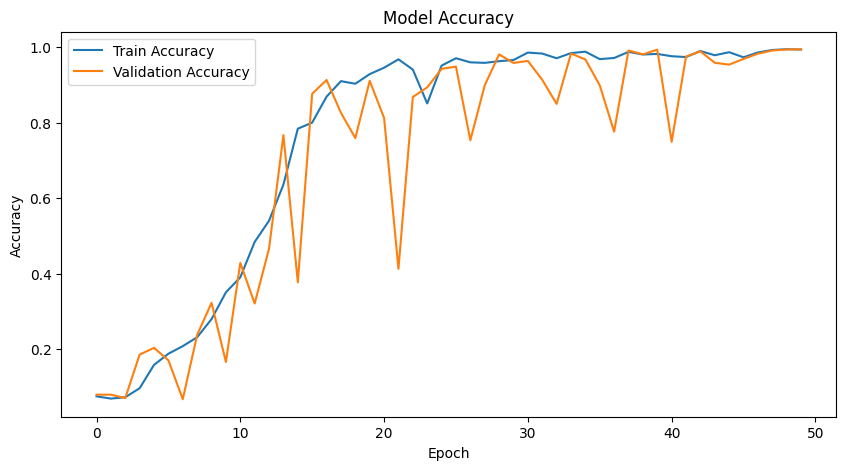

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Confusion Matrix Visualization
### Create and visualize a confusion matrix for model predictions.

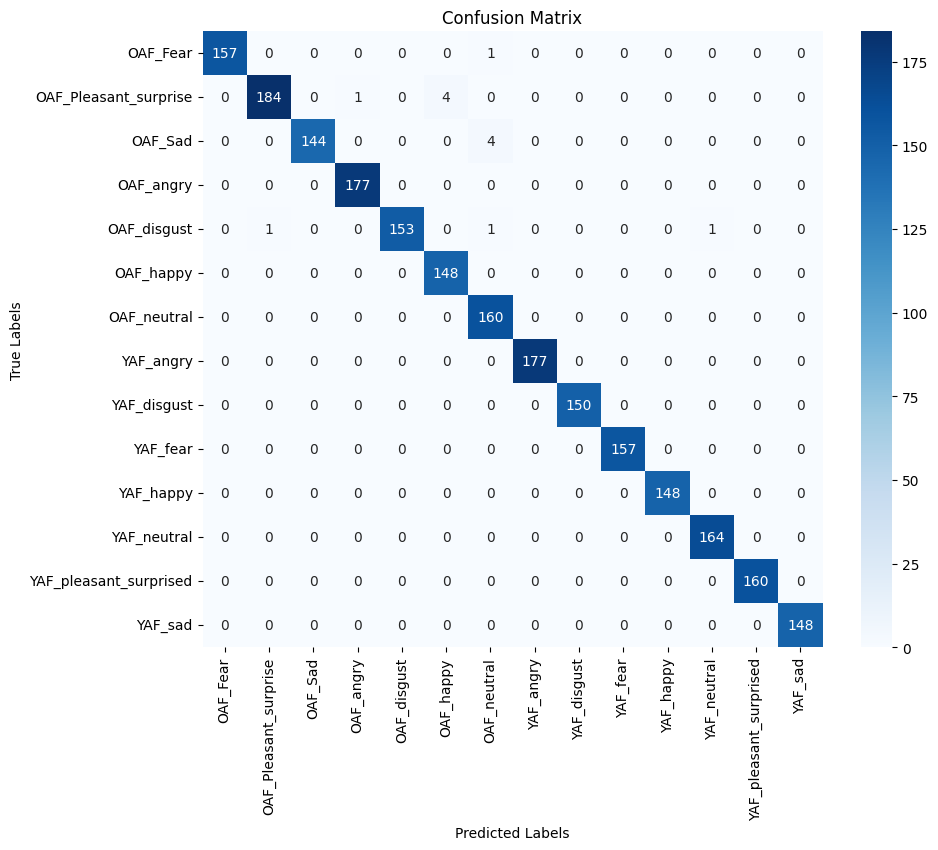

In [15]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
class_names = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Save the Trained Model
### Save the trained model in keras format for future use.

In [17]:
model_save_path = "Models/ser_model_50.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to Models/ser_model_50.keras
